## Rule-based classification with RandomForest

## Import Library dan Muat Dataset

memuat data awal dari file Excel dan menggabungkan data IB dan IK menjadi satu tabel.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud

In [2]:
file_path = "dataset.xlsx"

ib_data = pd.read_excel(file_path, sheet_name="DATA IB")
ik_data = pd.read_excel(file_path, sheet_name="DATA IK")

# kolom yang relevan --> 'keperluan'
ib_data = ib_data[["desc"]].rename(columns={"desc": "keperluan"})
ik_data = ik_data[["tujuan"]].rename(columns={"tujuan": "keperluan"})

ib_data["izin"] = "IB"
ik_data["izin"] = "IK"

combined_data = pd.concat([ib_data, ik_data], ignore_index=True)

# Bersihkan teks pada kolom 'keperluan'
combined_data["keperluan"] = combined_data["keperluan"].str.strip().str.lower()
combined_data.drop_duplicates(subset=['keperluan'], inplace=True)

combined_data.to_csv("combined_ib_ik_keperluan.csv", index=False)

print(combined_data.head())

                        keperluan izin
0         ingin bertemu orang tua   IB
2               libur akhir tahun   IB
3                  libur semester   IB
4               bertemu orang tua   IB
5  mengerjakan tugas proyek akhir   IB


## Exploratory Data Analysis (EDA)

Menganalisis informasi data yang telah digabungkan.

In [3]:
# Muat data
file_path = "combined_ib_ik_keperluan.csv"
data = pd.read_csv(file_path)

# Tampilkan informasi data
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  3439 non-null   object
 1   izin       3439 non-null   object
dtypes: object(2)
memory usage: 53.9+ KB
None
                        keperluan izin
0         ingin bertemu orang tua   IB
1               libur akhir tahun   IB
2                  libur semester   IB
3               bertemu orang tua   IB
4  mengerjakan tugas proyek akhir   IB


## Visualisasi Distribusi Kata pada Data "Keperluan"

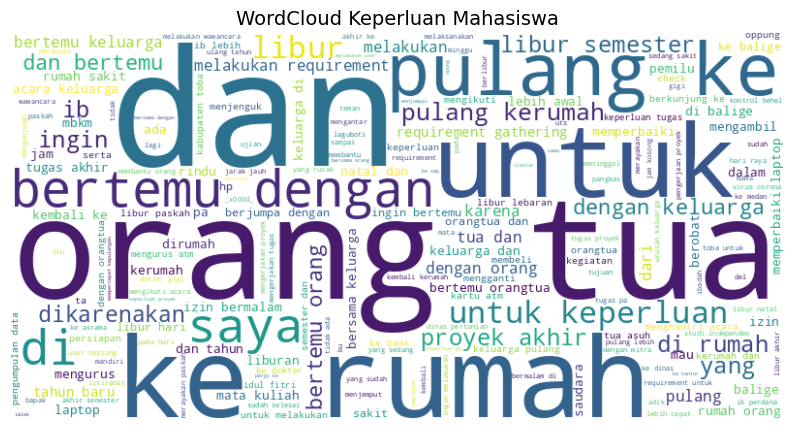

10 Kata Paling Umum dalam Keperluan:
dan: 807
ke: 678
untuk: 492
rumah: 402
pulang: 385
libur: 373
di: 360
keluarga: 352
bertemu: 346
orang: 341
tua: 304
melakukan: 294
dengan: 277
yang: 247
keperluan: 233
kerumah: 180
requirement: 172
ingin: 170
proyek: 166
ib: 161


In [4]:
# Hitung distribusi kata
all_keperluan = " ".join(data["keperluan"])
word_counts = Counter(all_keperluan.split())

# Tampilkan WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_keperluan)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Keperluan Mahasiswa", fontsize=14)
plt.show()

# Tampilkan kata paling umum
common_words = word_counts.most_common(20)
print("10 Kata Paling Umum dalam Keperluan:")
for word, count in common_words:
    print(f"{word}: {count}")


## Klasifikasi Data Berdasarkan Aturan

Mengklasifikasikan data kolom keperluan menjadi beberapa kategori menggunakan aturan berbasis regex.

In [5]:
# Klasifikasi keperluan
def classify_keperluan(text):
    if re.search(r"(laptop|printer|service|barang)", text):
        return "Memperbaiki Barang"
    elif re.search(r"(orangtua|orang tua|keluarga|saudara|pulang|rumah|bertemu|libur|pemilu|ib|pesta|pernikahan|natal|lebaran|paskah|acara|izin bermalam)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek akhir|PKM|tugas|makalah|requirement|observasi|pa 1|pa 2| pa 3|tugas akhir|akhir|data)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|behel|cabut|sakit|berobat|obat)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(membeli|barang|pribadi|mengurus|keperluan|rekening|tabungan|kartu)", text):
        return "Urusan Pribadi"
    elif re.search(r"(exit|clearance|wisuda)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

data["kategori"] = data["keperluan"].apply(classify_keperluan)


print(data["kategori"].value_counts())

data.to_csv("categorized_keperluan.csv", index=False)


kategori
Bertemu Keluarga      1942
Lainnya                690
Tugas Kuliah           334
Urusan Pribadi         191
Memperbaiki Barang     141
Pergi ke Klinik        121
Tamat Kuliah            20
Name: count, dtype: int64


In [6]:
opp_data = pd.read_csv("categorized_keperluan.csv")
opp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  3439 non-null   object
 1   izin       3439 non-null   object
 2   kategori   3439 non-null   object
dtypes: object(3)
memory usage: 80.7+ KB


## Label Encoding

Konversi kategori menjadi nilai numerik.

In [7]:
label_encoder = LabelEncoder()

# Mengencode semua kolom bertipe 'object'
for column in opp_data.select_dtypes(include=["object"]).columns:
    opp_data[column + "_encoded"] = label_encoder.fit_transform(opp_data[column])

print("Data Setelah Encoding:")
print(opp_data.head())

opp_data.info()

Data Setelah Encoding:
                        keperluan izin          kategori  keperluan_encoded  \
0         ingin bertemu orang tua   IB  Bertemu Keluarga                701   
1               libur akhir tahun   IB  Bertemu Keluarga               1171   
2                  libur semester   IB  Bertemu Keluarga               1345   
3               bertemu orang tua   IB  Bertemu Keluarga                365   
4  mengerjakan tugas proyek akhir   IB      Tugas Kuliah               2140   

   izin_encoded  kategori_encoded  
0             0                 0  
1             0                 0  
2             0                 0  
3             0                 0  
4             0                 5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   keperluan          3439 non-null   object
 1   izin               3439 non-null  

In [8]:
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(opp_data["keperluan"])


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Memisahkan fitur dan target
X = np.hstack((X_tfidf.toarray(), opp_data[["izin_encoded"]].values))
y = opp_data["kategori_encoded"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(class_weight="balanced", max_depth=10, n_estimators=50)
model.fit(X_train, y_train)

# Evaluasi
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       391
           1       0.79      0.76      0.77       147
           2       0.58      0.85      0.69        26
           3       0.85      0.92      0.88        24
           4       0.50      1.00      0.67         4
           5       0.85      0.94      0.89        64
           6       0.65      0.94      0.77        32

    accuracy                           0.87       688
   macro avg       0.74      0.90      0.80       688
weighted avg       0.89      0.87      0.87       688

Accuracy: 0.87


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)


Best Params: {'max_depth': 10, 'n_estimators': 50}


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
print(f"Mean Accuracy: {scores.mean():.2f}")


Mean Accuracy: 0.82


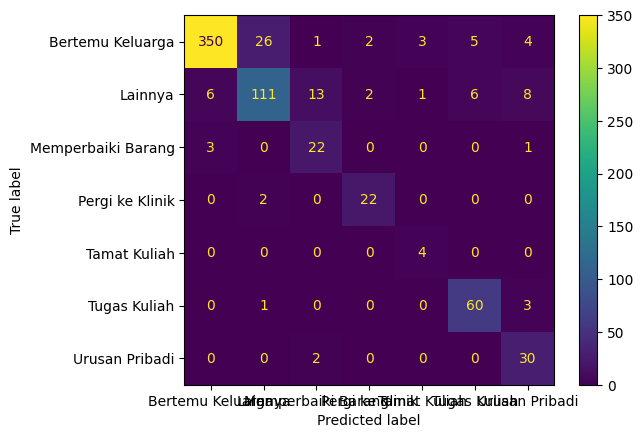

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_encoder.classes_)
plt.show()


Distribusi Kategori Prediksi:
Kategori 0: 359 data
Kategori 5: 71 data
Kategori 1: 140 data
Kategori 3: 26 data
Kategori 6: 46 data
Kategori 2: 38 data
Kategori 4: 8 data


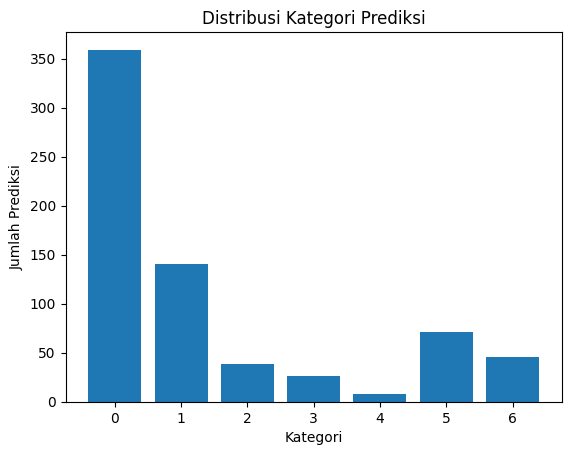

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

# Prediksi pada data testing
y_pred = model.predict(X_test)

# Distribusi kategori
category_counts = Counter(y_pred)
print("Distribusi Kategori Prediksi:")
for category, count in category_counts.items():
    print(f"Kategori {category}: {count} data")

# Visualisasi
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel("Kategori")
plt.ylabel("Jumlah Prediksi")
plt.title("Distribusi Kategori Prediksi")
plt.show()


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Pisahkan data berdasarkan kategori
categories = opp_data["kategori"].unique()

for category in categories:
    category_data = opp_data[opp_data["kategori"] == category]["keperluan"]
    tfidf = TfidfVectorizer(max_features=10)  # Ambil 10 fitur teratas
    X_tfidf = tfidf.fit_transform(category_data)
    feature_names = tfidf.get_feature_names_out()
    
    # Print kata-kata dominan
    print(f"\nKategori: {category}")
    print("Kata-Kata Dominan:")
    for word, score in zip(feature_names, X_tfidf.toarray().mean(axis=0)):
        print(f"{word}: {score:.4f}")



Kategori: Bertemu Keluarga
Kata-Kata Dominan:
bertemu: 0.1047
dan: 0.1506
ke: 0.1139
keluarga: 0.1402
libur: 0.1545
orang: 0.0940
pulang: 0.1317
rumah: 0.1348
tua: 0.0909
untuk: 0.0718

Kategori: Tugas Kuliah
Kata-Kata Dominan:
akhir: 0.1711
dan: 0.1149
ke: 0.1589
keperluan: 0.1295
melakukan: 0.1827
pa: 0.1500
proyek: 0.1836
requirement: 0.2455
tugas: 0.1571
untuk: 0.1945

Kategori: Lainnya
Kata-Kata Dominan:
balige: 0.0467
dan: 0.0790
di: 0.0771
hp: 0.0300
ke: 0.1110
melakukan: 0.0513
memperbaiki: 0.0593
testing: 0.0343
untuk: 0.0562
yang: 0.0455

Kategori: Pergi ke Klinik
Kata-Kata Dominan:
behel: 0.1819
berobat: 0.1861
dan: 0.1348
di: 0.0670
dokter: 0.1009
gigi: 0.2591
ke: 0.1121
kontrol: 0.1750
sakit: 0.1004
yang: 0.0776

Kategori: Urusan Pribadi
Kata-Kata Dominan:
atm: 0.1420
balige: 0.1050
bank: 0.0826
dan: 0.1366
kartu: 0.0876
ke: 0.1111
keperluan: 0.2832
mengurus: 0.2195
untuk: 0.1905
yang: 0.1038

Kategori: Memperbaiki Barang
Kata-Kata Dominan:
balige: 0.0732
barang: 0.1553
b

In [15]:
# Tambahkan prediksi ke dataframe
opp_data["predicted_category"] = model.predict(X)

# Analisis kata-kata dominan pada kategori prediksi
for category in opp_data["predicted_category"].unique():
    category_data = opp_data[opp_data["predicted_category"] == category]["keperluan"]
    tfidf = TfidfVectorizer(max_features=10)
    X_tfidf = tfidf.fit_transform(category_data)
    feature_names = tfidf.get_feature_names_out()

    print(f"\nPrediksi Kategori: {category}")
    print("Kata-Kata Dominan:")
    for word, score in zip(feature_names, X_tfidf.toarray().mean(axis=0)):
        print(f"{word}: {score:.4f}")



Prediksi Kategori: 0
Kata-Kata Dominan:
bertemu: 0.1059
dan: 0.1483
dengan: 0.0693
ke: 0.1239
keluarga: 0.1454
libur: 0.1712
orang: 0.1024
pulang: 0.1502
rumah: 0.1489
tua: 0.0993

Prediksi Kategori: 5
Kata-Kata Dominan:
akhir: 0.1681
dan: 0.1124
ke: 0.1523
keperluan: 0.1198
melakukan: 0.1754
pa: 0.1526
proyek: 0.2266
requirement: 0.2297
tugas: 0.1492
untuk: 0.1958

Prediksi Kategori: 1
Kata-Kata Dominan:
balige: 0.0372
dan: 0.0846
dari: 0.0272
di: 0.0780
ke: 0.0935
melakukan: 0.0498
saya: 0.0300
testing: 0.0311
untuk: 0.0429
yang: 0.0369

Prediksi Kategori: 6
Kata-Kata Dominan:
atm: 0.1672
balige: 0.1153
bank: 0.0800
dan: 0.1498
kartu: 0.0837
ke: 0.1121
keperluan: 0.2571
mengurus: 0.2159
untuk: 0.2092
yang: 0.1174

Prediksi Kategori: 3
Kata-Kata Dominan:
behel: 0.1662
berobat: 0.1766
dan: 0.1312
di: 0.0655
dokter: 0.1189
gigi: 0.2444
ke: 0.1269
kontrol: 0.1678
sakit: 0.1331
yang: 0.0931

Prediksi Kategori: 2
Kata-Kata Dominan:
balige: 0.0663
barang: 0.1207
dan: 0.1713
di: 0.0656
ke: 

In [16]:
from sklearn.metrics import roc_auc_score, f1_score

# Multi-class ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# F1 Score per kategori
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 Score: {f1:.2f}")


ROC-AUC Score: 0.98
F1 Score: 0.87


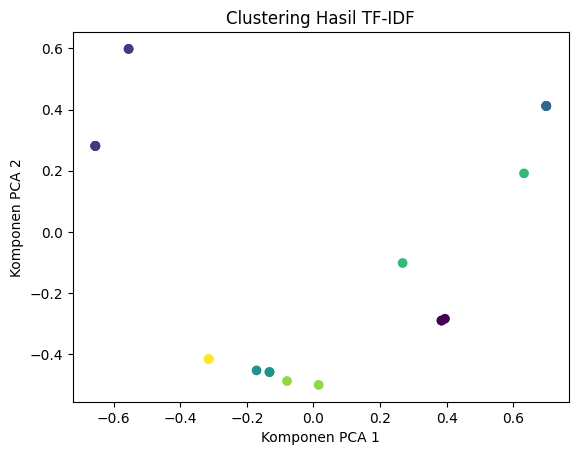

In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Clustering dengan KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Visualisasi dengan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.title("Clustering Hasil TF-IDF")
plt.xlabel("Komponen PCA 1")
plt.ylabel("Komponen PCA 2")
plt.show()


cluster  kategori          
0        Bertemu Keluarga      661
         Lainnya               627
         Urusan Pribadi        161
         Pergi ke Klinik       120
         Memperbaiki Barang    119
         Tugas Kuliah           29
         Tamat Kuliah           20
1        Bertemu Keluarga      178
         Memperbaiki Barang      2
2        Bertemu Keluarga      318
         Memperbaiki Barang      9
3        Bertemu Keluarga      305
         Memperbaiki Barang      8
4        Tugas Kuliah          305
         Lainnya                60
         Urusan Pribadi         30
         Bertemu Keluarga       26
         Memperbaiki Barang      2
         Pergi ke Klinik         1
5        Bertemu Keluarga      140
         Lainnya                 3
6        Bertemu Keluarga      314
         Memperbaiki Barang      1
Name: count, dtype: int64


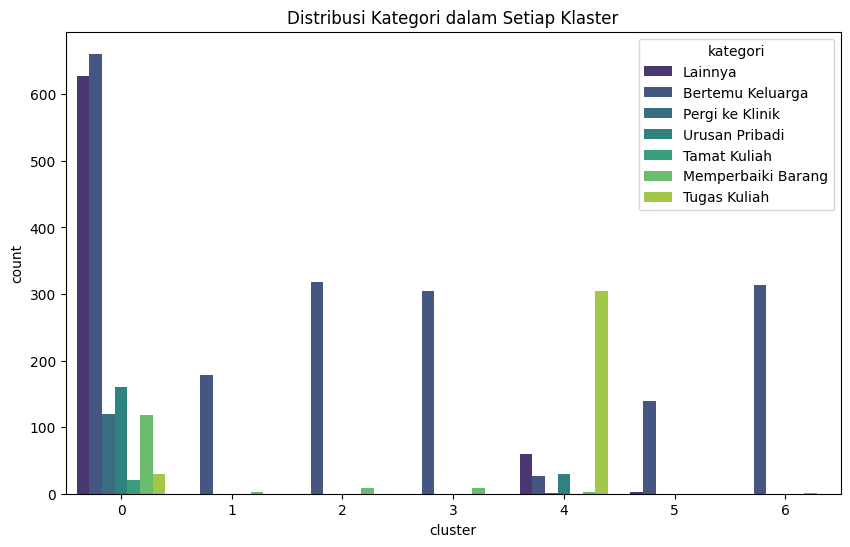

In [21]:
# Ulangi TF-IDF pada seluruh data
tfidf_full = TfidfVectorizer(max_features=1000)
X_tfidf_full = tfidf_full.fit_transform(opp_data["keperluan"])

# Klasterisasi
kmeans_full = KMeans(n_clusters=7, random_state=42)
clusters_full = kmeans_full.fit_predict(X_tfidf_full)

# Tambahkan hasil klaster ke dalam opp_data
opp_data["cluster"] = clusters_full

# Analisis distribusi
print(opp_data.groupby("cluster")["kategori"].value_counts())

# Visualisasi distribusi kategori dalam klaster
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x="cluster", hue="kategori", data=opp_data, palette="viridis")
plt.title("Distribusi Kategori dalam Setiap Klaster")
plt.show()


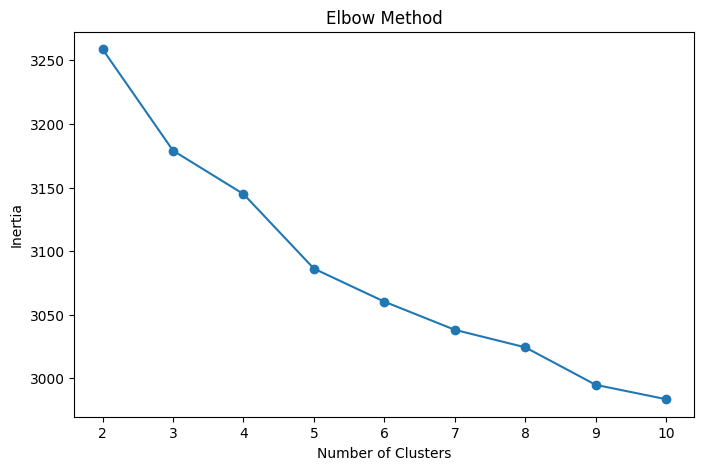

In [22]:
# Elbow Method
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf_full)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [23]:
from sklearn.metrics import silhouette_score

# Uji berbagai jumlah klaster
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    print(f"Jumlah Klaster: {n_clusters}, Silhouette Score: {score:.2f}")


Jumlah Klaster: 2, Silhouette Score: 0.31
Jumlah Klaster: 3, Silhouette Score: 0.38
Jumlah Klaster: 4, Silhouette Score: 0.49
Jumlah Klaster: 5, Silhouette Score: 0.55
Jumlah Klaster: 6, Silhouette Score: 0.57
Jumlah Klaster: 7, Silhouette Score: 0.68
Jumlah Klaster: 8, Silhouette Score: 0.75
Jumlah Klaster: 9, Silhouette Score: 0.73
